In [22]:
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np
import logging
from gym_duckietown.simulator import Simulator
from casadi import *
import sys
sys.path.insert(0,'..')
import utils
from utils import get_trajectory, get_position, my_odometry
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20

# Hyperparameters
gym_duckietown.logger.setLevel(logging.WARNING)
plt.rcParams['figure.figsize'] = [7, 7]
test_results = True
T = 15 # Simulation time
N = 10 # MPC horizon
n_from_index = 0 # How distant the first point is
frame_rate = 10

In [23]:
env = Simulator("ETH_large_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[3,1],
    seed=42,
    max_steps=float("inf"),
    robot_speed=1.0,
    frame_rate=frame_rate
)
#env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], pi/2]
env.unwrapped.start_pose = [[0.3, 0, 0.41029359288296474], pi/2]
dt = 1.0 / env.frame_rate
env.reset()
traj = get_trajectory(env, samples=200, method="distance", last_value_distance=1.0)
traj = traj + np.array([-1.25, -1.5])
inside, outside = utils.get_border(traj, distance=0.2)
x_min = traj[:,0].min()
y_min = traj[:,1].min()
#fig = plt.figure(constrained_layout=True, figsize=(10, 5))
#ax_dict = fig.subplot_mosaic("""AB""")
#ax_dict["A"].plot(*inside.T, "g--")
#ax_dict["A"].plot(*outside.T, "g--")
#utils.show_on_map_array(env, inside - np.array([-1.25, -1.5]), fig=ax_dict["B"])
#utils.show_on_map_array(env, outside- np.array([-1.25, -1.5]), fig=ax_dict["B"])
pose = get_position(env)
pose.x = 0.79
pose.y = 0.0
pose.theta = pi/2

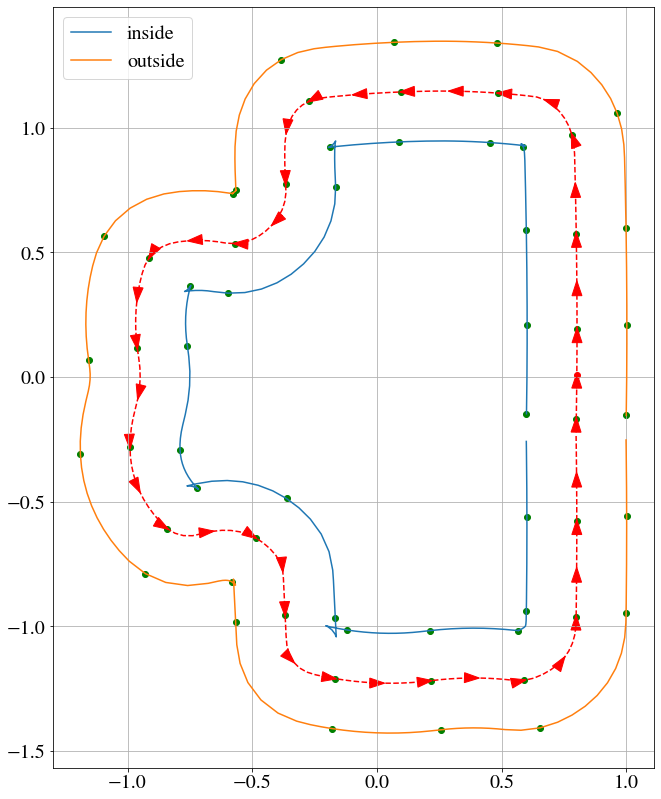

In [24]:
from scipy import spatial
distance,index = spatial.KDTree(traj).query([pose.x, pose.y])
pose.x = traj[index,0]
pose.y = traj[index,1]
index += n_from_index
fig = plt.figure(figsize=(14,14))
plt.plot(*traj.T, "r--")
plt.plot(*inside.T, label='inside')
plt.plot(*outside.T, label='outside')
plt.legend()
plt.scatter(pose.x, pose.y, c="r")
for idx in range(0,len(traj),10):
    plt.scatter(traj[idx,0], traj[idx,1], c="g")
    plt.scatter(inside[idx,0], inside[idx,1], c="g")
    plt.scatter(outside[idx,0], outside[idx,1], c="g")
plt.grid(True)
plt.gca().set_aspect('equal')
f"Samples must be at least: {np.round(np.sum( np.sqrt(np.sum( np.diff(traj, axis=0)**2, axis=1 )) ) / (0.6*dt))}"
#utils.show_on_map_array(env, traj[:,:2] - np.array([-1.25, -1.5]))
# Compute the angle between every consecutive points in traj
angles = np.zeros(traj.shape[0])
angles[:-1] = np.arctan2(traj[1:,1]-traj[:-1,1], traj[1:,0]-traj[:-1,0])
angles[-1] = np.arctan2(traj[0,1]-traj[-1,1], traj[0,0]-traj[-1,0])
angles[angles < 0] += 2 * np.pi
#idx = []
#for i in range(len(angles)-1):
#    if mod((angles[i] - angles[i+1]),pi) >= pi/2:
#        idx.append(i)
# Add angles to traj
traj = np.concatenate((traj, angles.reshape(-1,1)), axis=1)
c="r"
#fig = plt.figure(figsize=(14,14))
for x, y, t in traj[::5]:
    dx = 0.007*np.cos(t)
    if x+dx < x:
        c = 'r'#"b"
    else:
        c = "r"
    plt.arrow(x, y, dx, 0.007*np.sin(t), color=c, head_width=0.04, length_includes_head=True)

In [25]:
index = DM(index)
traj = DM(traj)

Initialize states, inputs, and system dynamic equation

[0.80163, 0.00853932, 1.5708, 0.3, 0]


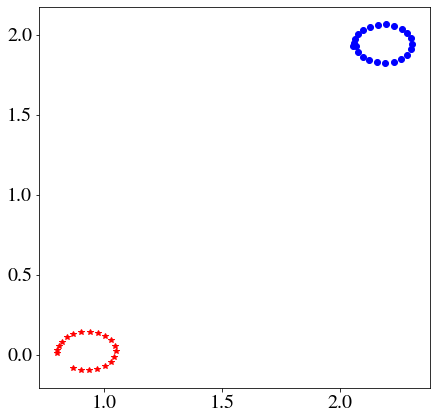

In [26]:
up = 5
wp = 4
# parameters for forced dynamics
u_alpha_r = 1.5
u_alpha_l = 1.5
w_alpha_r = 15  # modify this for trim
w_alpha_l = 15
# States
x0 = MX.sym('x')
y0 = MX.sym('y')
th0 = MX.sym('th')
v0 = MX.sym('v')
w0 = MX.sym('w')
x = vertcat(x0, y0, th0, v0, w0) # Always vertically concatenate the states --> [n_x,1]
# Inputs
wl = MX.sym('wl')
wr = MX.sym('wr')
u = vertcat(wl, wr) # Always vertically concatenate the inputs --> [n_u,1]
# System dynamics (CAN BE NONLINEAR! ;))
# x_long_dot_dot = -u1*v0 + u_alpha_r*wr + u_alpha_l*wl
# w_dot_dot = -w1*w0 + w_alpha_r*wr - w_alpha_l*wl
v1 = (1-up*dt)*v0 + u_alpha_r*dt*wr + u_alpha_l*dt*wl
w1 = (1-wp*dt)*w0 + w_alpha_r*dt*wr - w_alpha_l*dt*wl
x1 = x0 + v0*dt*np.cos(th0 + w0*dt/2)
y1 = y0 + v0*dt*np.sin(th0 + w0*dt/2)
# Cannot use atan2 because x1 and y1 are approximated while th1 is not
theta1 = th0 + w0*dt
dae = vertcat(x1, y1, theta1, v1, w1)
F = Function('F',[x,u],[dae],['x','u'],['dae'])
if test_results:
    print(F([pose.x, pose.y, pose.theta, 0, 0], [1, 1]))
N_test=20
# Test the problem definition
sim = F.mapaccum(N_test) # To call the F function N times
x0 = [pose.x, pose.y, pose.theta, 0, 0]

res = np.array(sim(x0, [1, 0.2]))
fig = plt.figure()
tgrid = np.linspace(0,T,N)
# plt.plot(tgrid, np.column_stack((x0, res)).T)
plt.plot(res[0, :], res[1, :], 'r*')
env.reset()
for action in [[1, 0.2]]*(N_test+3):
    obs, reward, done, info = env.step(action)
    p = get_position(env)
    plt.scatter(p.x, p.y, c='b')
_ = env.reset()

In [27]:
delay = round(0.15/dt)
u_delay0 = DM(np.zeros((2, delay)))
# N += delay

# Initial reference point
r0 = repmat(traj[index, :2].T, 1, N+1)
# Initial reference angles
t0 = repmat(traj[index, 2].T, 1, N+1)

# With preview
# Initial reference point
r0 = traj[index:index+N+1, :2].T
t0 = traj[index:index+N+1, 2].T
ins0 = DM(inside)[index:index+N+1, :].T
out0 = DM(outside)[index:index+N+1, :].T

In [28]:
#weights_0 = [1e3, 1e2, 1e-2, 1]
weights_0 = [1, 50, 50, 0, 0, 50]
theta_0 = [0, 0, 0, 0]
gamma = 0.9
u_prev_0 = [.0, .0]

In [29]:
def position_cost(x,r):
    delta = 10
    return delta**2 * (np.sqrt(1 + (((x[0]-r[0])**2 + (x[1]-r[1])**2)/delta**2))-1)
def heading_cost(psi,tr):
    return (1 - np.cos(psi - tr))/2

In [30]:
opti = Opti()
######################## VARIABLE/PARAMETERS ############################################################
x = opti.variable(5,N+1)            # States with dimension (n_x, prediction_horizon+1) (x(0),...,x(N+1))
u = opti.variable(2,N)#-delay)      # Inputs with dimension (n_u, prediction_horizon) (u(0),...,u(N))
slack1 = opti.variable(1,N)         # slack variable 1
slack2 = opti.variable(1,N)         # slack variable 2
p = opti.parameter(5,1)             # Parameter to set the initial state conditions (x(0))
r = opti.parameter(2,N+1)           # Parameter to set the reference position (r(0),...,r(N+1))
tr = opti.parameter(1,N+1)          # Parameter to set the reference angles
ins = opti.parameter(2,N+1)         # Parameter to set the inside boundary
out = opti.parameter(2,N+1)         # Parameter to set the outside boundary
u_delay = opti.parameter(2,delay)   # Parameter to set the delay (NOT USED)
u_prev = opti.parameter(2,1)        # Parameter to set previus input value (u(-1))
weights = opti.parameter(6)         # Parameter for the cost function weights  
theta = opti.parameter(4)           # Additional learned parameters
######################## COST FUNCTION WEIGHTS ############################################################
Q1 = weights[0]
Q2 = weights[1]
Q3 = weights[2]
Q4 = weights[3]
Q5 = weights[4]
R = weights[5]
theta_lambda = theta[0]
theta_f_1 = theta[1]
theta_f_2 = theta[2]
theta_f_3 = theta[3]
######################## INITIAL VALUES ############################################################
cost = theta_lambda +\
       Q1*sumsqr(x[:2, 0] - r[:,0]) +\
       Q2*heading_cost(x[2, 0],tr[:,0]) +\
       Q3*sumsqr(x[3, 0]-0.6) +\
       R*sumsqr(u[:,0]-u_prev)# initial cost

opti.subject_to(x[:,1]==F(x[:,0],u[:,0]))         # system dynamics (k=0)
opti.subject_to(x[:,0] == p)                      # set initial x_0
######################## STAGE COST/RECURSIVE CONTRAINTS ############################################################
for k in range(1,N):
    cost += gamma**k * (Q1*sumsqr(x[:2, k] - r[:,k]) +\
                        #Q2*sumsqr(fmin(2*np.pi - fabs(mod(x[2, k],2*pi)-tr[:,k]), fabs(mod(x[2, k],2*pi)-tr[:,k]))) +\
                        Q2*heading_cost(x[2, k],tr[:,k]) +\
                        Q3*sumsqr(x[3, k]-0.6) +\
                        #Q4*sumsqr(x[4, k]) +\
                        R*sumsqr(u[:,k]-u[:,k-1]) +\
                        1e1*slack1[:,k] + 1e1*slack2[:,k]
                        )
    opti.subject_to(x[:,k+1]==F(x[:,k],u[:,k]))
    opti.subject_to(sumsqr(x[:2,k]) + slack1[:,k] >= sumsqr(ins[:,k]))
    opti.subject_to(sumsqr(x[:2,k]) - slack2[:,k] <= sumsqr(out[:,k]))
######################## TERMINAL COST/CONSTRAINTS ############################################################
cost += gamma**N * (theta_f_1*sumsqr(x[:2, N]-r[:,N])+ theta_f_2*heading_cost(x[2, k],tr[:,k]) + theta_f_3*sumsqr(x[3, k]-0.6))
######################## ADDITIONAL PARAMETERS ############################################################
opti.subject_to(vec(u) <= 1)               # actuator LB
opti.subject_to(vec(u) >= -1)              # actuator LB
opti.subject_to(x[3,:] >= 0)               # Enforce forward movement
opti.subject_to(vec(slack1) >= 0)          # slack 1 condition
opti.subject_to(vec(slack2) >= 0)          # slack 2 condition
######################## INITIALIZE PARAMETERS ############################################################
opti.set_value(p,[pose.x, pose.y, pose.theta, 0, 0]) # Set the initial x0 value
opti.set_value(r,r0) # Set the initial reference points
opti.set_value(tr,t0) # Set the initial reference angles
opti.set_value(ins,ins0) # Set the initial reference angles
opti.set_value(out,out0) # Set the initial reference angles
opti.set_value(u_delay, u_delay0) # Initial delay
opti.set_value(u_prev, u_prev_0) # Initial delay
opti.set_value(weights, weights_0)
opti.set_value(theta, theta_0) 
######################## SOLVER SPECIFICATIONS ############################################################
# Ipopt
opts = dict()
opts["ipopt.print_level"] = 0
opts["print_time"] = False
opti.solver('ipopt',opts)
opti.minimize(cost)
######################## CREATE VALUE FUNCTION V(s) ############################################################
V = opti.to_function('V',[p, r, tr, ins, out, u_delay, u_prev, weights, theta], # inputs
                         [cost, u[:,0], gradient(cost + opti.lam_g.T @ opti.g, weights), gradient(cost + opti.lam_g.T @ opti.g, theta)], # outputs
                         ['p', 'r', 'tr', 'ins', 'out','u_delay', 'u_prev', 'weights', 'theta'],
                         ['cost', 'u_opt', 'gradient_weights', 'gradient_theta'])
######################## TESTING ############################################################
# Test over 1 time horizon
if test_results:
    sol = opti.solve()

In [31]:
u_s = [.0, .0]
opti = Opti()

x = opti.variable(5,N+1)    # States with dimension (n_x, prediction_horizon+1) (x(0),...,x(N+1))
u = opti.variable(2,N)#-delay)      # Inputs with dimension (n_u, prediction_horizon) (u(0),...,u(N))
slack1 = opti.variable(1,N)
slack2 = opti.variable(1,N)
p = opti.parameter(5,1)     # Parameter to set the initial state conditions (x(0))
r = opti.parameter(2,N+1)   # Parameter to set the initial index
tr = opti.parameter(1,N+1)   # Parameter to set the initial reference angles
ins = opti.parameter(2,N+1)   # Inside reference
out = opti.parameter(2,N+1)   # Outside reference
u_delay = opti.parameter(2,delay) # Parameter to set the delay
u_prev = opti.parameter(2,1)
u_0 = opti.parameter(2)

weights = opti.parameter(6)
theta = opti.parameter(4)
#beta = opti.parameter(1)

#beta1 = beta[0]
#beta2 = beta[1]

Q1 = weights[0]
Q2 = weights[1]
Q3 = weights[2]
Q4 = weights[3]
Q5 = weights[4]
R = weights[5]

theta_lambda = theta[0]
theta_f_1 = theta[1]
theta_f_2 = theta[2]
theta_f_3 = theta[3]

# With delay:
# Q, Q2, Q3, R = 100, 5e-4, 1, 1e-3
#obj = Q*sumsqr(x[:2, :]-r) + Q2*sumsqr(mod(x[2, :]-tr+pi, 2*pi)-pi) + Q3*sumsqr(x[3, :]-0.6) + R*sumsqr(u)#R*sumsqr(u[:,1:]-u[:,:-1])
# atan method is faster than mod (20s vs 23s on 1000 iterations) but it allows car to go backward
# obj = Q*sumsqr(x[:2, :]-r) + Q2*sumsqr(atan2(sin(x[2, :]-tr), cos(x[2, :]-tr))) + R*sumsqr(u)

        # Setup the problem 

# Constraints Definition
# Constraints Definition
cost = theta_lambda +\
       Q1*sumsqr(x[:2, 0] - r[:,0]) +\
       Q2*heading_cost(x[2, 0],tr[:,0]) +\
       Q3*sumsqr(x[3, 0]-0.6) +\
       R*sumsqr(u[:,0]-u_prev)# initial cost

# 1) System dynamics constraint over the prediction horizon
for k in range(1,N):
    cost += gamma**k * (Q1*sumsqr(x[:2, k] - r[:,k]) +\
                        #Q2*sumsqr(fmin(2*np.pi - fabs(mod(x[2, k],2*pi)-tr[:,k]), fabs(mod(x[2, k],2*pi)-tr[:,k]))) +\
                        Q2*heading_cost(x[2, k],tr[:,k]) +\
                        Q3*sumsqr(x[3, k]-0.6) +\
                        #Q4*sumsqr(x[4, k]) +\
                        R*sumsqr(u[:,k]-u[:,k-1]) +\
                        1e1*slack1[:,k] + 1e1*slack2[:,k]
                        )
    # opti.subject_to(x[:,k+1]==F(x[:,k],horzcat(u_delay, u)[:, k])) # Horzacat to include delay
    opti.subject_to(x[:,k+1]==F(x[:,k],u[:,k]))
    opti.subject_to(sumsqr(x[:2,k]) + slack1[:,k] >= sumsqr(ins[:,k]))
    opti.subject_to(sumsqr(x[:2,k]) - slack2[:,k] <= sumsqr(out[:,k]))    
#cost += Q5*sumsqr(curvature(x[0, :],x[1, :]))
cost += gamma**N * (theta_f_1*sumsqr(x[:2, N]-r[:,N])+ theta_f_2*heading_cost(x[2, k],tr[:,k]) + theta_f_3*sumsqr(x[3, k]-0.6))

opti.subject_to(x[:,1]==F(x[:,0],u[:,0]))
# 2) Additional states/inputs constraints 
opti.subject_to(vec(u) <= 1)
opti.subject_to(vec(u) >= -1)
#opti.subject_to(sumsqr(x[:2,:]) >= sumsqr(r[:,:]))
opti.subject_to(x[3,:] >= 0)
# 3) Force the state variable at instant 0 to be equal to the parameter value containing x0 value
opti.subject_to(x[:,0] == p)
opti.subject_to(u[:,0] == u_0)
opti.subject_to(vec(slack1) >= 0)
opti.subject_to(vec(slack2) >= 0)

opti.set_value(p,[pose.x, pose.y, pose.theta, 0, 0]) # Set the initial x0 value
opti.set_value(r,r0) # Set the initial reference points
opti.set_value(tr,t0) # Set the initial reference angles
opti.set_value(ins,ins0) # Set the initial reference angles
opti.set_value(out,out0) # Set the initial reference angles
opti.set_value(u_delay, u_delay0) # Initial delay
opti.set_value(u_prev, u_prev_0) # Initial delay
opti.set_value(u_0, u_s)

opti.set_value(weights, weights_0)
opti.set_value(theta, theta_0)

opti.minimize(cost)

# Ipopt
opts = dict()
opts["ipopt.print_level"] = 0
opts["print_time"] = False
opti.solver('ipopt',opts)

# Test over 1 time horizon
if test_results:
    sol = opti.solve()
    
Q = opti.to_function('Q',[p, r, tr, ins, out, u_delay, u_prev, u_0, weights, theta], # inputs
                         [cost, gradient(cost + opti.lam_g.T @ opti.g, weights), gradient(cost + opti.lam_g.T @ opti.g, theta)], # outputs
                         ['p', 'r', 'tr', 'ins', 'out', 'u_delay', 'u_prev', 'u_0', 'weights', 'theta'],
                         ['cost', 'gradient_weigths', 'gradient_theta'])

In [ ]:
from skspatial.objects import Line
from IPython import display as ipythondisplay

def stage_cost(x, r, tr, x_next, x_prev):
    return 1/(x[3]+1e-6)**2
    
# MPC loop
gamma = 0.9
alpha_1 = 5e-1
alpha_2 = 5e-1
#weights_0 = [100, 5e-4, 10, 1e-3]
#weights_0 = [1e3, 1e2, 1e-2, 1]
weights_0 = [1, 10, 1, 0, 0, 5]
#weights_0 = [1, 86.8694, 36.2108, 0, 0, 59.3382] # test
#weights_0 = [1, 3.35397, 11.2813, 0, 0, 5.75866] # speed, 111
#weights_0 = [-116.279, 5.42188, 48.3061, 0, 0, 54.4139] # curvature, 111
#weights_0 = [-37.6498, 64.0978, 32.4645, 0, 0, 33.5779] # curvature 001
#weights_0 = [0.809252, 0, 0.110079, 0, 0, 0] # for example
#weights_0 =[1.51838, 0, 1.13578, 0, 0, 0] # example with 10 weights on w
#weights_0 = [0.543969, 0.0379773, 0.0787006, 0, 0, 0] # with heading cost
#weights_0 = [0.787901, 0.0211029, 0.0806473, 0, 0, 0] #  with theta
#weights_0 = [0.273273, 0.059044, 0.0869923, 0, 0, 0] # 15k steos
#weights_0 = [0.837962, 0.000163317, 0.0322027, 0, 0, 0]# for ref speed 0.2
#weights_0 = [0.956418, 0.00251801, -0.00141281, 0, 0, 0.0216092] # for ref speed 0.2
#weights_0 = [1, 14.7023, 15.9597, 0, 0, 0] # for curvature
#weights_0 = [1, 7.13518, 10.1238, 0, 0, 0]# for curvature 2
#weights_0 = [1, 9.61111, 11.9599, 0, 0, 0] # for curvature 3
#weights_0 = [1, 824.037, 480.801, 0, 0, 0] # for curvature inside traj
#weights_0 = [1, 1.99024, 1.89642, 0, 0, 0] # for curvature inside traj 2
#theta_0 = [100, 1, 1, 1]
theta_0 = [0, 0, 0, 0]
#theta_0 = [21.6513, 0, 0, 0] # test
#theta_0 = [33.2431, 0, 0, 0] # speed, 111
#theta_0 = [-30.6233, 0, 0, 0]# curvature, 111
#theta_0 = [17.5736, 0, 0, 0] # curvature 001
#theta_0 = [0, -0.0342125, 0.000601827, -0.00644741]
#theta_0 = [2.27957, -0.118842, -0.00167384, -0.0227207] # 15k steps
#theta_0 = [187.82, 0.25294, -0.0283084, -0.356778] # for curvature
#theta_0 = [92.7182, 0, 0, 0] # for curvature 3
#theta_0 = [3254.27, -22.1191, -0.303924, -26.7503] # for curvature inside traj
#theta_0 = [30.0249, 0.205885, 0.0110286, -0.11331] # for curvature inside traj 2
#weights_0 = [100, 0.0148332, 10.054, 1.08164] # tuned, original 100, 5e-4, 10, 1e-3, max_speed = 0.3891 (non tuned 0.5260)
#weights_0 = [100, 0.0207271, 10.027, 0.710063] # tuned new stage cost, original 100, 5e-4, 10, 1e-3, max_speed = 0.3891 (non tuned 0.5260)
#theta_0 = [1.92382e-06, 2.81897e-09, 0.000776342] # tuned
#theta_0 = [1.17951e-06, 4.02384e-09, -2.73673e-05] # tuned stage cost new
#weights_0 = [106.582, 68.6181, 10.05, 0.106237] # test
#theta_0 = [0.111024, 1.45679, 1.56981] # test
#weights_0 = [102.703, 28.9963, 10.0181, 0.0282763] # test 2
#theta_0 = [0.0258132, 0.62772, 10.0108] # test 2

lap_dict = dict()

autotune = True

X_log = np.empty((5,0))
U_log = np.empty((2,0))

x = [pose.x, pose.y, pose.theta, 0, 0]
start_angle = np.arctan2(x[1], x[0])
start_angle = start_angle if start_angle >= 0 else start_angle + 2*np.pi


x_prev = x
r = r0
tr = t0
ins = ins0
out = out0
idx = index
u_delay = u_delay0
u_prev = u_prev_0
errors = []
error_x = []
error_y = []
error_theta = []
it_vect = []
weights_vect = []
theta_vect = []
delta_vect = []
grad_weights_vect = []
grad_theta_vect = []
stage_cost_vect = []

kdtree = spatial.KDTree(traj[:, :2])

_,start_idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))

x_prev = x
i_prev = 0

t = 0
flag = False

#fig, ax = plt.subplots()

#ax.plot(traj[:,0], traj[:,1], "b--")
#ax.plot(*inside.T, "b")
#ax.plot(*outside.T, "b")
#t1 = ax.text(1.2, 1.5,"Iteration: 0, Last time: {:.2f}s".format(X_log.shape[1]*dt), ha='center', va='center')
#plt.draw()

for i in range(500000):
    #if i == 3500:
    #    alpha_1 = 3e-1
    #elif i==4500:
    #    alpha_1 = 1e-2
    #elif i==5000:
    #    alpha_1 = 1e-3
    #print(i)
    V_cost, a, _, _ = V(x, r, tr, ins, out, u_delay, u_prev, weights_0, theta_0)
    #print(V_cost)
    
    U_log = np.column_stack((U_log, a))
    X_log = np.column_stack((X_log, x))

    #u_delay = np.column_stack((u_delay, a))[:, -delay:]

    # simulate
    x_next = F(x,a)
    
    
    Q_cost, Q_grad_weights, Q_grad_theta = Q(x, r, tr, ins, out, u_delay, u_prev, a, weights_0, theta_0)
    #print(Q_grad)
    #
    #print(stage_cost(x, r, tr))
    #print(stage_cost_model(x, r, tr, weights_0, a))
    
    #print(delta)
    #print(abs(delta))
    #test = [1e3, 1e3, 1, 1e-1]
    #test2 = [1, 1e3, 1e3]
    #print(test * Q_grad_weights)
    #print(test2 * Q_grad_theta)
    #print(stage_cost(x, r, tr, x_next, x_prev))
    l = stage_cost(x, r, tr, x_next, x_prev)
    delta = l + gamma * V(x_next, r, tr, ins, out, u_delay, u_prev, weights_0, theta_0)[0] - Q_cost

    if autotune and i >= 20:
        #lr = alpha_1 * (1. / (1. + 0.005 * i))
        lr = alpha_1
        weights_0 = weights_0 + lr * delta * Q_grad_weights
        weights_0[0] = 1 # keep Q1 fixed
        for j in range(weights_0.shape[0]):
            if weights_0[j] < 0.01:
                weights_0[j] = 0.01
        theta_0 = theta_0 + lr * delta * Q_grad_theta
        theta_0[1:] = [0, 0, 0]

    x_prev = x
    u_prev = a
    x = x_next
    
    distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
    it_vect.append(i)
    errors.append(np.sqrt(distance))
    error_x.append(traj[idx, 0] - x[0])
    error_y.append(traj[idx, 1] - x[1])
    error_theta.append(mod(x[2],2*np.pi)-traj[idx, 2])
    weights_vect.append(DM(weights_0))
    theta_vect.append(DM(theta_0))
    delta_vect.append(delta)
    grad_weights_vect.append(Q_grad_weights)
    grad_theta_vect.append(Q_grad_theta)
    stage_cost_vect.append(l)
    
    _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
    
    current_angle = np.arctan2(x[1], x[0])
    current_angle = current_angle if current_angle >= 0 else current_angle + 2*np.pi

    if i > 5 and (float(current_angle) - start_angle >= - 0.05 and float(current_angle) - start_angle <= 0.05):
        print('Lap %i'%(len(lap_dict)+1))
        lap_dict[len(lap_dict)+1] = [it_vect[i_prev:], X_log[:,i_prev:], U_log[:,i_prev:], delta_vect[i_prev:], weights_vect[i_prev:], theta_vect[i_prev:], stage_cost_vect[i_prev:]]
        i_prev = i
    
    if idx+N+1 < traj.shape[0]:
        r = traj[idx:idx+N+1, :2].T
        tr = traj[idx:idx+N+1, 2].T
        ins = DM(inside)[idx:idx+N+1, :].T
        out = DM(outside)[idx:idx+N+1, :].T
    else:
        r = vertcat(traj[idx:, :2], traj[:idx+N+1-traj.shape[0], :2]).T
        tr = vertcat(traj[idx:, 2], traj[:idx+N+1-traj.shape[0], 2]).T
        ins = vertcat(DM(inside)[idx:, :], DM(inside)[:idx+N+1-inside.shape[0], :]).T
        out = vertcat(DM(outside)[idx:, :], DM(outside)[:idx+N+1-inside.shape[0], :]).T
        
    #if len(lap_dict)+1==50: # 30 ok
        #break
        #ax.plot(*X_log[:2,:], c='r')
        #ax.text(0,0,"Steps: {iteration} Last time: {time:.2f}s".format(iteration=i, time=X_log.shape[1]*dt))
        #plt.draw()
        #ipythondisplay.clear_output(wait=True)
        #ipythondisplay.display(plt.gcf())
    #r = traj[idx:idx+N+1, :2].T
    #tr = traj[idx:idx+N+1, 2].T

Lap 1
Lap 2
Lap 3
Lap 4
Lap 5
Lap 6
Lap 7
Lap 8
Lap 9
Lap 10
Lap 11
Lap 12
Lap 13
Lap 14
Lap 15
Lap 16
Lap 17
Lap 18
Lap 19
Lap 20
Lap 21
Lap 22
Lap 23
Lap 24
Lap 25
Lap 26
Lap 27
Lap 28
Lap 29
Lap 30
Lap 31
Lap 32
Lap 33
Lap 34
Lap 35
Lap 36
Lap 37
Lap 38
Lap 39
Lap 40
Lap 41
Lap 42
Lap 43
Lap 44
Lap 45
Lap 46
Lap 47
Lap 48
Lap 49
Lap 50
Lap 51
Lap 52
Lap 53
Lap 54
Lap 55
Lap 56
Lap 57
Lap 58
Lap 59
Lap 60
Lap 61
Lap 62
Lap 63
Lap 64
Lap 65
Lap 66
Lap 67
Lap 68
Lap 69
Lap 70
Lap 71
Lap 72
Lap 73
Lap 74
Lap 75
Lap 76
Lap 77
Lap 78
Lap 79
Lap 80
Lap 81
Lap 82
Lap 83
Lap 84
Lap 85
Lap 86
Lap 87
Lap 88
Lap 89
Lap 90
Lap 91
Lap 92
Lap 93
Lap 94
Lap 95
Lap 96
Lap 97
Lap 98
Lap 99
Lap 100
Lap 101
Lap 102
Lap 103
Lap 104
Lap 105
Lap 106
Lap 107
Lap 108
Lap 109
Lap 110
Lap 111
Lap 112
Lap 113
Lap 114
Lap 115
Lap 116
Lap 117
Lap 118
Lap 119
Lap 120
Lap 121
Lap 122
Lap 123
Lap 124
Lap 125
Lap 126
Lap 127
Lap 128
Lap 129
Lap 130
Lap 131
Lap 132
Lap 133
Lap 134
Lap 135
Lap 136
Lap 137
Lap 138
Lap 

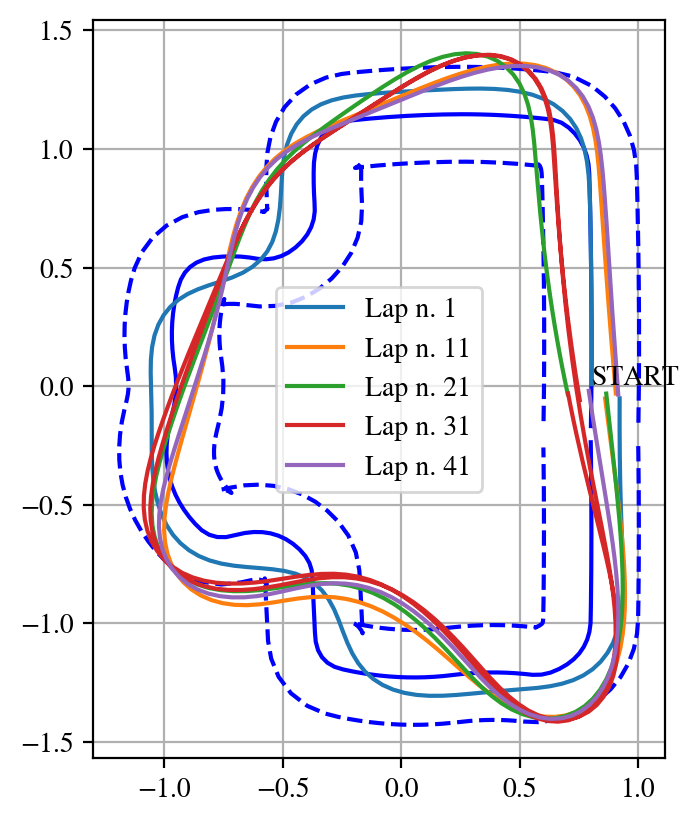

In [13]:
fig = plt.figure(constrained_layout=True, dpi=200)
traj = np.array(traj)
index = int(index)
ax_dict = fig.subplot_mosaic("""A""")
ax_dict["A"].plot(traj[:,0], traj[:,1], "b")
ax_dict["A"].plot(inside[:,0], inside[:,1], "b--")
ax_dict["A"].plot(outside[:,0], outside[:,1], "b--")
ax_dict["A"].text(X_log[0,0], X_log[1,0], 'START')

for i, (key, val) in enumerate(lap_dict.items()):
    #print(val[1].shape)
    #ax_dict["A"].plot(val[1][0,:], val[1][1,:], label='Lap n. %i'%(i+1))
    if i%10==0:
        ax_dict["A"].plot(val[1][0,:], val[1][1,:], label='Lap n. %i'%(i+1))
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal')

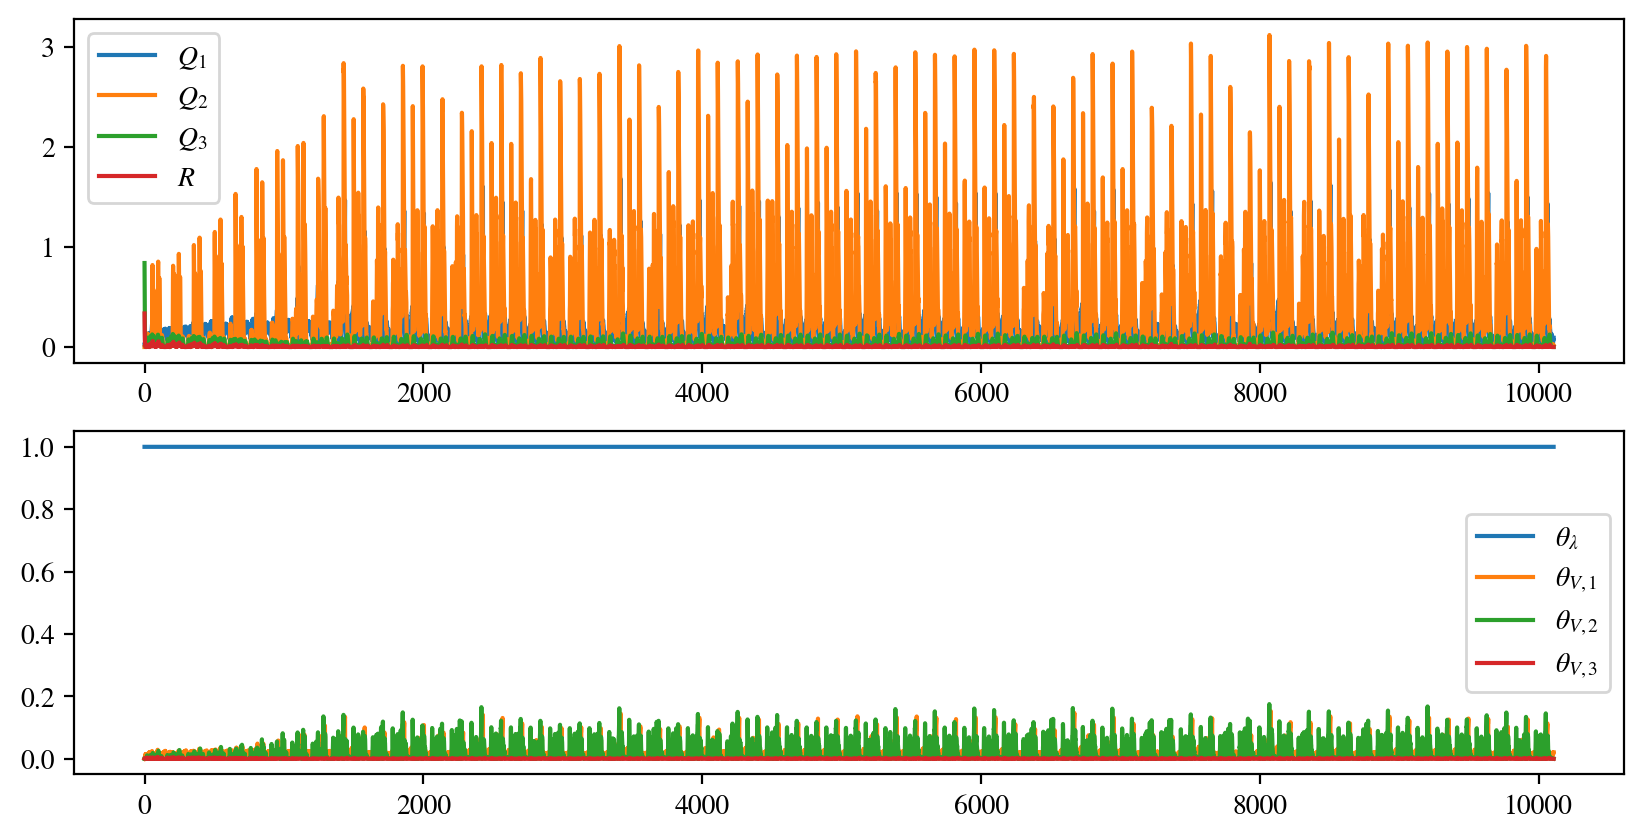

In [14]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,5), dpi=200)

ax1.plot(np.array(grad_weights_vect).reshape(-1,6)[:,0], label='$Q_1$')
ax1.plot(np.array(grad_weights_vect).reshape(-1,6)[:,1], label='$Q_2$')
ax1.plot(np.array(grad_weights_vect).reshape(-1,6)[:,2], label='$Q_3$')
#ax1.plot(np.array(grad_weights_vect).reshape(-1,6)[:,3], label='$Q_4$')
#ax1.plot(np.array(grad_weights_vect).reshape(-1,6)[:,4], label='$Q_5$')
ax1.plot(np.array(grad_weights_vect).reshape(-1,6)[:,5], label='$R$')
ax1.legend()

ax2.plot(np.array(grad_theta_vect).reshape(-1,4)[:,0], label=r'$\theta_{\lambda}$')
ax2.plot(np.array(grad_theta_vect).reshape(-1,4)[:,1], label=r'$\theta_{V,1}$')
ax2.plot(np.array(grad_theta_vect).reshape(-1,4)[:,2], label=r'$\theta_{V,2}$')
ax2.plot(np.array(grad_theta_vect).reshape(-1,4)[:,3], label=r'$\theta_{V,3}$')
ax2.legend()

In [15]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [20]:
import pickle as pkl
save = False
if save:
    with open('vars/logs_1,50,50,50_lr_1e-1.pickle', 'wb') as handle:
        pkl.dump(lap_dict, handle, protocol=pkl.HIGHEST_PROTOCOL)

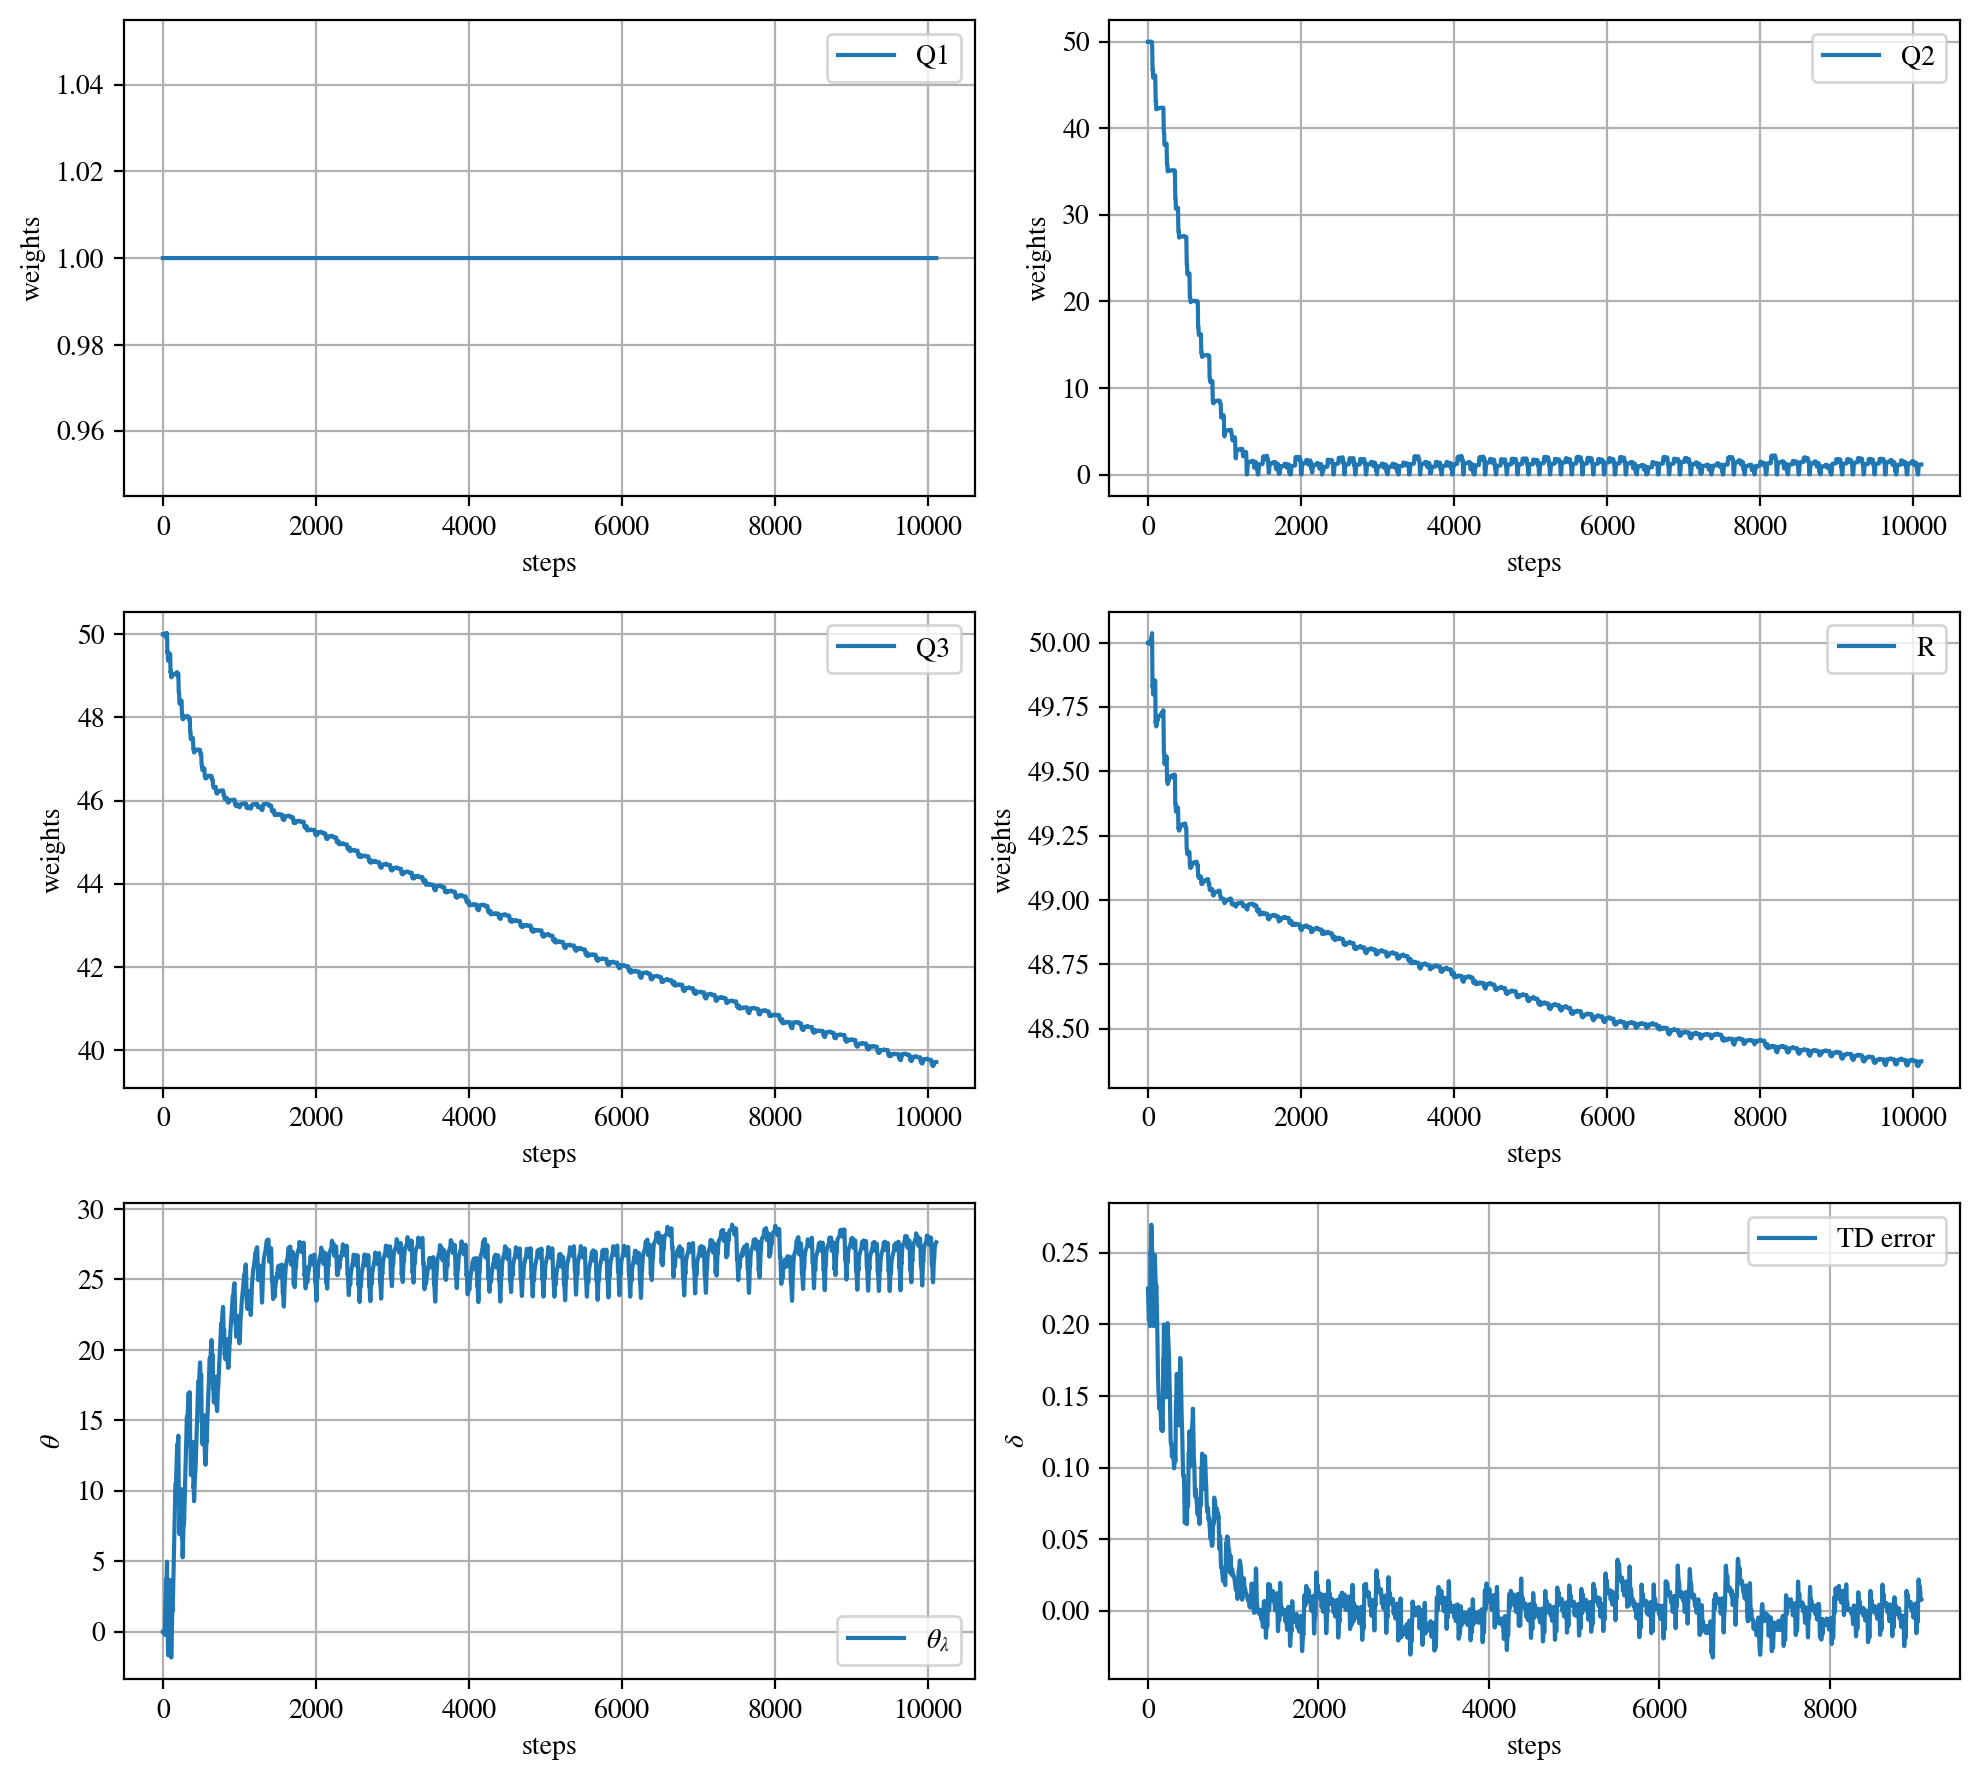

In [17]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2,constrained_layout=False, figsize=(10, 9), dpi=200)
ax1.plot(np.array(weights_vect).reshape(-1,6)[:,0], label='Q1')
ax1.legend()
ax1.set_xlabel('steps')
ax1.set_ylabel('weights')
ax1.grid(True)

ax2.plot(np.array(weights_vect).reshape(-1,6)[:,1], label='Q2')
ax2.legend()
ax2.set_xlabel('steps')
ax2.set_ylabel('weights')
ax2.grid(True)

ax3.plot(np.array(weights_vect).reshape(-1,6)[:,2], label='Q3')
ax3.legend()
ax3.grid(True)
ax3.set_xlabel('steps')
ax3.set_ylabel('weights')

ax4.plot(np.array(weights_vect).reshape(-1,6)[:,5], label='R')
ax4.legend()
ax4.grid(True)
ax4.set_xlabel('steps')
ax4.set_ylabel('weights')

ax5.plot(np.array(theta_vect).reshape(-1,4)[:,0], label=r'$\theta_{\lambda}$')
#ax1.plot(np.array(theta_vect).reshape(-1,4)[:,1], label=r'$\theta_{V,1}$')
#ax1.plot(np.array(theta_vect).reshape(-1,4)[:,2], label=r'$\theta_{V,2}$')
#ax1.plot(np.array(theta_vect).reshape(-1,4)[:,3], label=r'$\theta_{V,3}$')
ax5.legend()
ax5.set_xlabel('steps')
ax5.set_ylabel(r'$\theta$')
ax5.grid(True)

ax6.plot(moving_average(np.array(delta_vect[30:]).flatten(), 1000), label='TD error')
ax6.legend()
#ax2.plot(np.array(delta_vect).flatten())
ax6.grid(True)
ax6.set_xlabel('steps')
ax6.set_ylabel(r'$\delta$')

plt.tight_layout()
plt.show()

<>:9: DeprecationWarning: invalid escape sequence \e


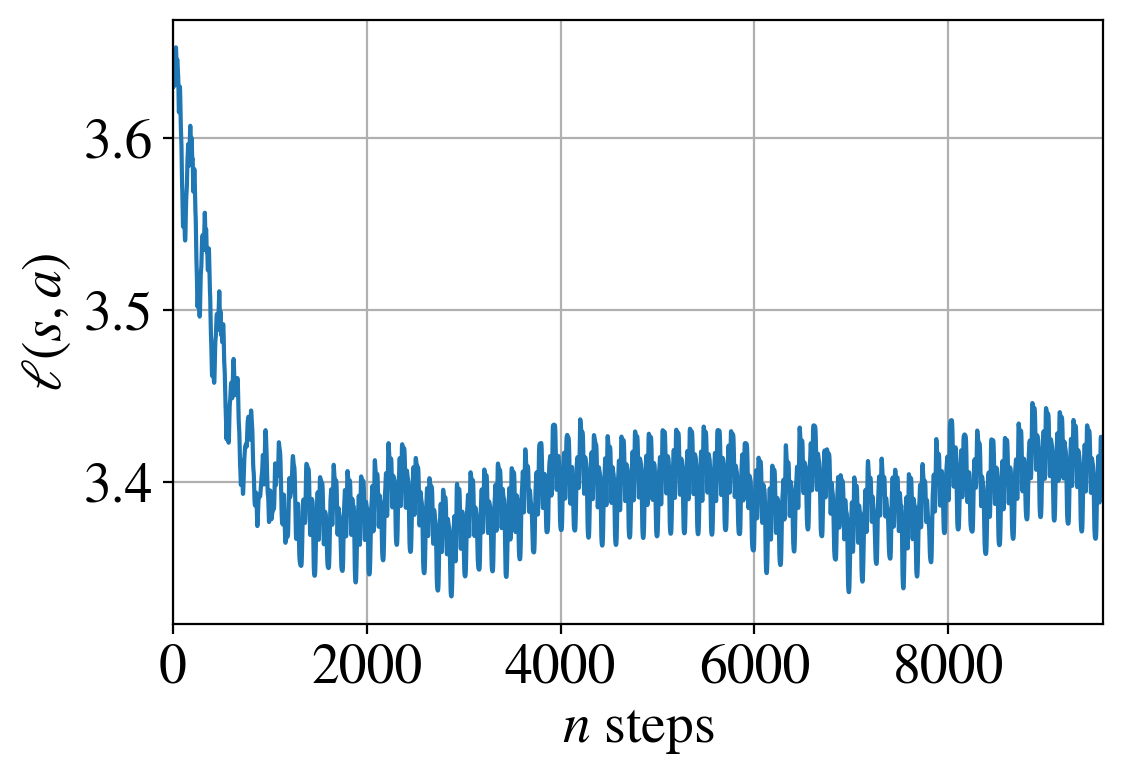

In [18]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
fig = plt.figure(dpi=200)
plt.plot(moving_average(np.array(stage_cost_vect[10:]).flatten(), 500))
ax1 = plt.gca()
ax1.set_xlabel('$n$ steps')
ax1.set_ylabel('$\ell(s,a)$')
ax1.grid(True)
ax1.margins(x=0)
plt.show()
#fig.savefig('prova.eps')

In [119]:
print('weights_vect: ', weights_vect[-1])
print('theta_vect: ', theta_vect[-1])

weights_vect:  [1, 0.201214, 70.2693, 0.01, 0.01, 0.0100005]
theta_vect:  [27.4649, 0, 0, 0]


Con offset costante su x = 0.005, a partire da beta = 0.0 converge a 0.010 (10000 steps)
Con offset costante su x = 0.01, a partire da beta = 0.0 converge a ?? (10000 steps)
Con offset costante su x = 0.005, a partire da beta = 0.01 converge a ?? (10000 steps)

In [ ]:
weights_vect[-1]

In [ ]:
f"Max reached speed: {X_log[3,:].max()}, max speed is 0.6"

In [ ]:
np.mean(X_log[3,:])

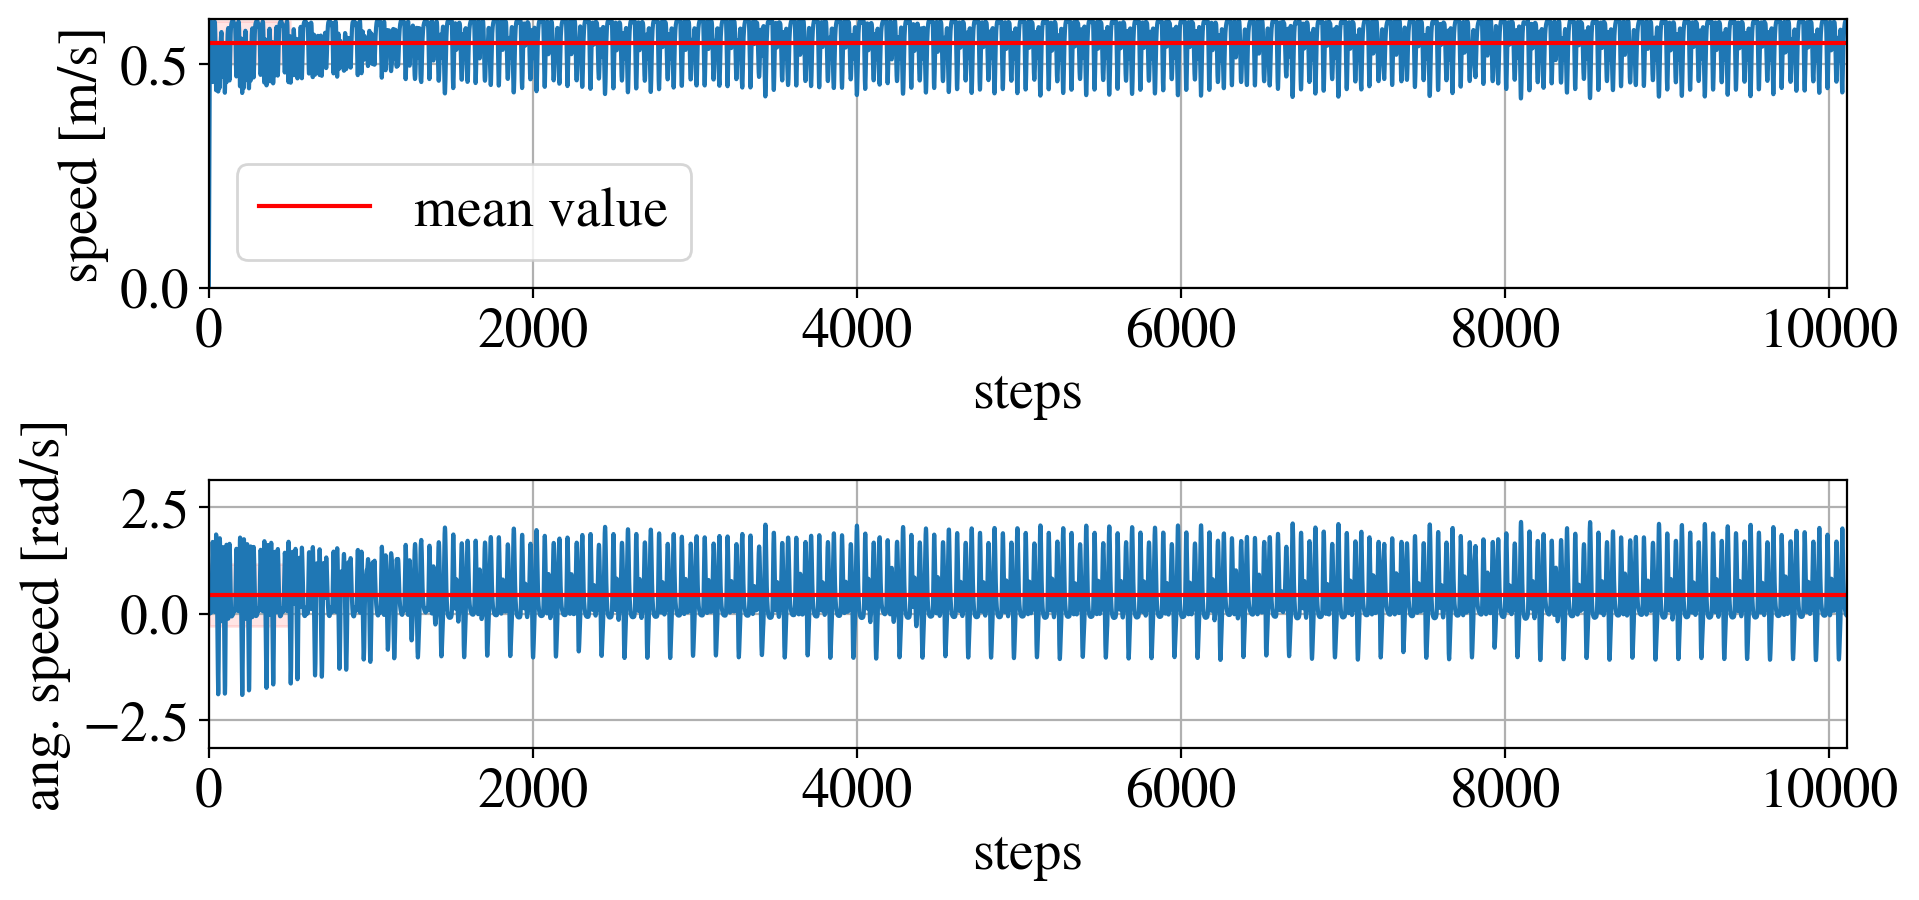

In [19]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,5), dpi=200)
ax1.plot(moving_average(X_log[3,:],1))
ax1.axhline(np.mean(X_log[3,:]), c='r', label='mean value')
ax1.fill_between(np.arange(500), np.mean(X_log[3,:])-np.std(X_log[3,:]),np.mean(X_log[3,:])+np.std(X_log[3,:]), color='r', alpha=0.1)
ax1.grid(True)
ax1.set_xlabel('steps')
ax1.set_ylabel('speed [m/s]')
ax1.set_ylim(0,0.6)
ax1.margins(x=0)
ax1.legend()

ax2.plot(moving_average(X_log[4,:],1))
ax2.axhline(np.mean(X_log[4,:]), c='r', label='mean value')
ax2.fill_between(np.arange(500), np.mean(X_log[4,:])-np.std(X_log[4,:]),np.mean(X_log[4,:])+np.std(X_log[4,:]), color='r', alpha=0.1)
ax2.grid(True)
ax2.set_xlabel('steps')
ax2.set_ylabel('ang. speed [rad/s]')
ax2.set_ylim(-np.pi,np.pi)
ax2.margins(x=0)
plt.tight_layout()

In [ ]:
errors = np.array(errors).reshape(-1)
f"Mean error: {errors.mean()}"

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5), dpi=200)
traj = np.array(traj)
index = int(index)
ax_dict = fig.subplot_mosaic("""AC""")
ax_dict["A"].text(X_log[0,0], X_log[1,0], 'START')
ax_dict["A"].plot(traj[:,0], traj[:,1], "b")
ax_dict["A"].plot(inside[:,0], inside[:,1], "b--")
ax_dict["A"].plot(outside[:,0], outside[:,1], "b--")
ax_dict["A"].plot(traj[index,0], traj[index,1], 'go')
ax_dict["A"].plot(X_log[0,:], X_log[1,:], "r")
ax_dict["A"].plot(traj[idx, 0], traj[idx,1], 'yo')
utils.show_on_map_array(env, np.array([X_log[0,:], X_log[1,:]]).T  - np.array([-1.25, -1.5]), fig=ax_dict["C"])

In [149]:
t*1/10

0.0

In [150]:
print(np.mean(np.abs(curvature_val_observed_tuned_curv).flatten()[np.abs(curvature_val_observed_tuned_curv).flatten() < 0.5]))
print(np.mean(np.abs(curvature_val_observed_tuned_speed).flatten()[np.abs(curvature_val_observed_tuned_speed).flatten() < 0.5]))
print(np.mean(np.abs(curvature_val_observed_non_tuned).flatten()[np.abs(curvature_val_observed_non_tuned).flatten() < 0.5]))

NameError: name 'curvature_val_observed_tuned_curv' is not defined

In [162]:
#print(np.sum(np.abs(curvature_val_observed_tuned_curv)))
#print(np.sum(np.abs(curvature_val_observed_tuned_speed)))
#print(np.sum(np.abs(curvature_val_observed_non_tuned)))
print(np.mean(np.abs(curvature_val_observed_tuned_curv)))
print(np.mean((curvature_val_observed_tuned_speed)))
print(np.mean((curvature_val_observed_non_tuned)))

1.4127206736134856


NameError: name 'curvature_val_observed_tuned_speed' is not defined

In [160]:
#curvature_val_reference = curvature(traj[:,0], traj[:,1])
curvature_val_observed_tuned_curv = curvature(X_log[0,:], X_log[1,:])
#curvature_val_observed_tuned_speed = curvature(X_log[0,:], X_log[1,:])
#curvature_val_observed_non_tuned = curvature(X_log[0,:], X_log[1,:])
#curvature_val = curvature(r[0,:], r[1,:])
#plt.plot(np.array(curvature_val))
plt.figure(figsize=(15,4),dpi=200)
plt.plot(np.abs(np.array(curvature_val_observed_non_tuned)), label='not tuned')
plt.plot(np.abs(np.array(curvature_val_observed_tuned_curv)), label='tuned - curvature')
plt.plot(np.abs(np.array(curvature_val_observed_tuned_speed)), label='tuned - speed')
plt.margins(x=0)
plt.grid(True)
plt.legend()
plt.xlabel('steps')
plt.ylabel('curvature')

NameError: name 'curvature_val_observed_non_tuned' is not defined

<Figure size 3000x800 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,5), dpi=200)
#plt.xticks(np.arange(0, len(errors)*dt+1, 1.0))
plt.plot(moving_average(np.sqrt(errors), 5))
plt.axhline(y=0.025, color='r', linestyle='-')
plt.xlabel("steps")
plt.ylabel("Distance from reference (m)")
plt.grid(True)

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(16, 10))
ax_dict = fig.subplot_mosaic("""A
        B
        C""")
error_x = np.array(error_x).reshape(-1)
ax_dict["A"].plot(np.arange(len(error_x))*dt, np.abs(error_x))
ax_dict["A"].set_title("Error in x")
ax_dict["A"].set_ylabel("Distance from x (m)")
error_y = np.array(error_y).reshape(-1)
ax_dict["B"].plot(np.arange(len(error_y))*dt, np.abs(error_y))
ax_dict["B"].set_title("Error in y")
ax_dict["B"].set_ylabel("Distance from y (m)")
error_theta_scaled = np.rad2deg(np.array(error_theta).reshape(-1))
ax_dict["C"].plot(np.arange(len(error_theta_scaled))*dt, np.abs(error_theta_scaled))
ax_dict["C"].set_title("Error in theta")
ax_dict["C"].set_ylabel("Distance from theta (deg)")
ax_dict["C"].set_xlabel("Time (s)")

## Parameters sensitivity

In [ ]:
td_graph = False

### Multi parameter sensitivity

In [484]:
if td_graph:
    errors_Q = []

    for Q_ in np.logspace(-4, 2, 20):
        errors_Q2 = []
        for Q2_ in np.logspace(-4, 2, 20):
            X_log = np.empty((5,0))
            U_log = np.empty((2,0))

            x = [pose.x, pose.y, pose.theta, 0, 0]
            r = r0
            tr = t0
            idx = index
            u_delay = u_delay0
            errors = []
            error_x = []
            error_y = []
            error_theta = []

            kdtree = spatial.KDTree(traj[:, :2])
            for i in range(50):
                u = M(x, r, tr, u_delay, Q_, Q2_, 1, 1)

                U_log = np.column_stack((U_log, u))
                X_log = np.column_stack((X_log, x))

                u_delay = np.column_stack((u_delay, u))[:, -delay:]

                # simulate
                x = F(x,u)

                distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
                errors.append(distance)
                error_x.append(traj[idx, 0] - x[0])
                error_y.append(traj[idx, 1] - x[1])
                error_theta.append(mod(x[2]-traj[idx, 2]+pi, 2*pi)-pi)

                _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
                r = traj[idx:idx+N+1, :2].T
                tr = traj[idx:idx+N+1, 2].T
            errors_Q2.append(np.array(errors).reshape(-1).sum())
        errors_Q.append(errors_Q2)

In [485]:
if td_graph:
    import matplotlib.ticker as mticker
    import matplotlib as mpl

    mpl.style.use("default")
    ax = plt.axes(projection='3d')
    ax.plot_wireframe(np.log10(np.logspace(-4, 2, 20)), np.log10(np.logspace(-4, 2, 20)), np.array(errors_Q), label="J")

    # My axis should display 10⁻¹ but you can switch to e-notation 1.00e+01
    def log_tick_formatter(val, pos=None):
        return f"$10^{{{int(val)}}}$"  # remove int() if you don't use MaxNLocator
        #return f"{10**val:.2e}"      # e-Notation

    ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
    ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    ax.set_xlabel('Q1', fontsize=15, rotation=0, labelpad=10)
    ax.set_ylabel('Q2', fontsize=15, labelpad=15)
    ax.set_zlabel('J', fontsize=15, rotation=0, labelpad=10)
    ax.yaxis.set_rotate_label(False)

    ax.grid(True)

    ax.set_title('Q1 vs Q2')

#### Sensitivity to Q1/Q2
FIxed Q3 and R

In [38]:
errors_Q = []

for Q_ in np.logspace(-2, 3, 30):
    X_log = np.empty((5,0))
    U_log = np.empty((2,0))

    x = [pose.x, pose.y, pose.theta, 0, 0]
    r = r0
    tr = t0
    idx = index
    u_delay = u_delay0
    errors = []
    error_x = []
    error_y = []
    error_theta = []

    kdtree = spatial.KDTree(traj[:, :2])
    for i in range(50):
        u = M(x, r, tr, u_delay, Q_, 1, 1e-2, 1)

        U_log = np.column_stack((U_log, u))
        X_log = np.column_stack((X_log, x))

        u_delay = np.column_stack((u_delay, u))[:, -delay:]

        # simulate
        x = F(x,u)

        distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
        errors.append(distance)
        error_x.append(traj[idx, 0] - x[0])
        error_y.append(traj[idx, 1] - x[1])
        error_theta.append(mod(x[2]-traj[idx, 2]+pi, 2*pi)-pi)

        _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
        r = traj[idx:idx+N+1, :2].T
        tr = traj[idx:idx+N+1, 2].T
    errors_Q.append(np.array(errors).reshape(-1).sum())

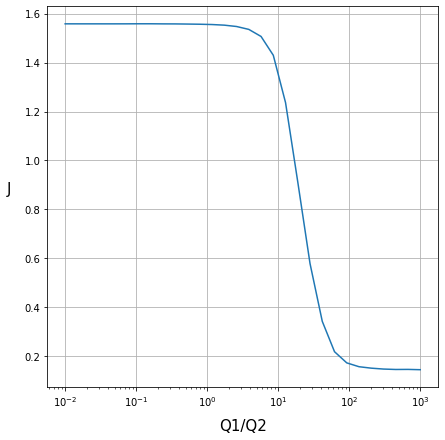

In [61]:
fig, ax = plt.subplots()
x = np.logspace(-2, 3, 30)
ax.plot(x, errors_Q)
ax.set_xlabel('Q1/Q2', fontsize=15, rotation=0, labelpad=10)
ax.set_ylabel('J', fontsize=15, labelpad=15, rotation=0)
ax.grid()

# Set x scale to logarithmic
ax.set_xscale('log')

### Sensitivity to Q1 vs Q3

In [57]:
errors_Q2 = []

for Q2_ in np.logspace(-2, 3, 30):
    X_log = np.empty((5,0))
    U_log = np.empty((2,0))

    x = [pose.x, pose.y, pose.theta, 0, 0]
    r = r0
    tr = t0
    idx = index
    u_delay = u_delay0
    errors = []

    kdtree = spatial.KDTree(traj[:, :2])
    for i in range(50):
        u = M(x, r, tr, u_delay, Q2_, 1e-2, 1, 1)

        U_log = np.column_stack((U_log, u))
        X_log = np.column_stack((X_log, x))

        u_delay = np.column_stack((u_delay, u))[:, -delay:]

        # simulate
        x = F(x,u)

        distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
        errors.append(distance)

        _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
        r = traj[idx:idx+N+1, :2].T
        tr = traj[idx:idx+N+1, 2].T
    errors_Q2.append(np.array(errors).reshape(-1).sum())

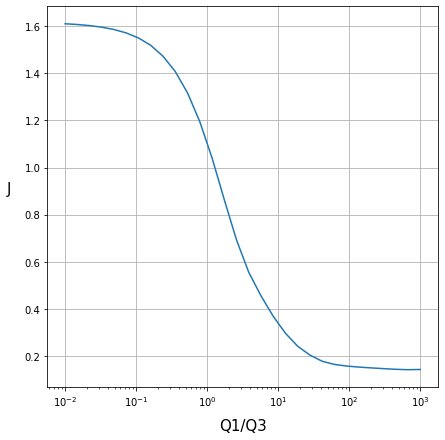

In [63]:
fig, ax = plt.subplots()
x = np.logspace(-2, 3, 30)
ax.plot(x, errors_Q2)
ax.set_xlabel('Q1/Q3', fontsize=15, rotation=0, labelpad=10)
ax.set_ylabel('J', fontsize=15, labelpad=15, rotation=0)
ax.grid()

# Set x scale to logarithmic
ax.set_xscale('log')

### Sensitivity to Q2/Q3

In [91]:
errors_Q3 = []

for Q3_ in np.logspace(-5, 5, 40):
    X_log = np.empty((5,0))
    U_log = np.empty((2,0))

    x = [pose.x, pose.y, pose.theta, 0, 0]
    r = r0
    tr = t0
    idx = index
    u_delay = u_delay0
    errors = []

    kdtree = spatial.KDTree(traj[:, :2])
    for i in range(50):
        u = M(x, r, tr, u_delay, 1e2, Q3_, 1, 1)

        U_log = np.column_stack((U_log, u))
        X_log = np.column_stack((X_log, x))

        u_delay = np.column_stack((u_delay, u))[:, -delay:]

        # simulate
        x = F(x,u)

        distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
        errors.append(distance)

        _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
        r = traj[idx:idx+N+1, :2].T
        tr = traj[idx:idx+N+1, 2].T
    errors_Q3.append(np.array(errors).reshape(-1).sum())

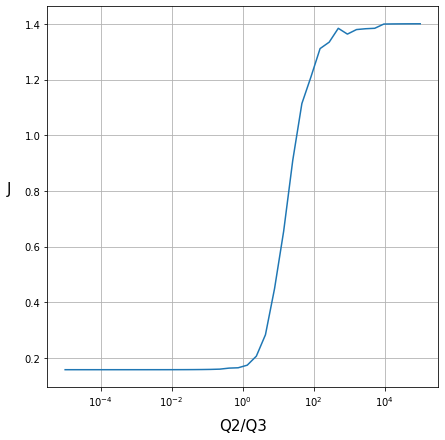

In [92]:
fig, ax = plt.subplots()
x = np.logspace(-5, 5, 40)
ax.plot(x, errors_Q3)

ax.set_xlabel('Q2/Q3', fontsize=15, rotation=0, labelpad=10)
ax.set_ylabel('J', fontsize=15, labelpad=15, rotation=0)
ax.grid()

# Set x scale to logarithmic
ax.set_xscale('log')

### Sensitivity to R

In [45]:
sens_R = False

if sens_R:
    errors_R = []

    for R_ in np.logspace(-4, 2, 20):
        X_log = np.empty((5,0))
        U_log = np.empty((2,0))

        x = [pose.x, pose.y, pose.theta, 0, 0]
        r = r0
        tr = t0
        idx = index
        u_delay = u_delay0
        errors = []

        kdtree = spatial.KDTree(traj[:, :2])
        for i in range(50):
            u = M(x, r, tr, u_delay, 100, 5e-4, 1, R_)

            U_log = np.column_stack((U_log, u))
            X_log = np.column_stack((X_log, x))

            u_delay = np.column_stack((u_delay, u))[:, -delay:]

            # simulate
            x = F(x,u)

            distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
            errors.append(distance)

            _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
            r = traj[idx:idx+N+1, :2].T
            tr = traj[idx:idx+N+1, 2].T
        errors_R.append(np.array(errors).reshape(-1).sum())

In [ ]:
if sens_R:
    fig, ax = plt.subplots()
    x = np.logspace(-4, 2, 20)
    ax.plot(x, errors_R)

    # Set x scale to logarithmic
    ax.set_xscale('log')

If you want to save the MPC controller, i.e. the M function for later use, you can do it!

In [ ]:
M.save('M.casadi')

### Gym simulation

The MPC does not consider the delay yet!

In [ ]:
record = False

if record:
    import imageio
    import cv2

    env.reset()
    pose = get_position(env)
    images = []
    positions = []
    odoms = [pose]
    actions = [[0,0]]*10
    v0 = 0
    w0 = 0
    for action in U_log.T:
        env.step(action)
        positions.append(get_position(env))
        img = env.render(mode='rgb_array')
        img = cv2.resize(img, dsize=(400, 300), interpolation=cv2.INTER_CUBIC)
        images.append(img)

        p, v0, w0 = my_odometry(action, odoms[-1].x, odoms[-1].y, odoms[-1].theta, v0, w0, dt=dt)
        odoms.append(p)
        actions.append(action)

    imageio.mimsave("assets/mpc_run.gif", images, format='GIF', fps=env.frame_rate)

In [ ]:
if record:
    plt.plot(*np.array([[p.x, p.y] for p in positions]).T, c='g', label='true', linewidth=5)
    plt.plot(*np.array([[p.x, p.y] for p in odoms]).T, c='r', label='odom')
    plt.legend()

In [ ]:
if record:
    utils.show_on_map(env, positions)

In [ ]:
from IPython.display import HTML, display
# Trick to prevent cache use
display(HTML('<img src="assets/mpc_run.gif?%d" width="750" align="center">' % np.random.randint(10)))